In [1]:
import os
from glob import glob
from datetime import datetime

from scipy import interpolate
from pytmatrix import orientation, radar, tmatrix_aux, refractive
from pytmatrix.psd import PSDIntegrator, GammaPSD
from pytmatrix.tmatrix import TMatrix, Scatterer
from pytmatrix.tmatrix_psd import TMatrixPSD, GammaPSD

import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from tqdm import tqdm

import common

In [2]:
file_list = sorted(glob('/g/data/kl02/jss548/PST/disdrometer/MtView/*.csv'))

pcm_matrix =(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)

diameter = np.array(
        [0.062, 0.187, 0.312, 0.437, 0.562, 0.687, 0.812, 0.937, 1.062, 1.187, 1.375, 1.625, 1.875, 2.125,
         2.375, 2.75, 3.25, 3.75, 4.25, 4.75, 5.5, 6.5, 7.5, 8.5, 9.5, 11, 13, 15, 17, 19, 21.5, 24.5])
velocity = np.array(
        [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.1, 1.3, 1.5, 1.7, 1.9,
         2.2, 2.6, 3, 3.4, 3.8, 4.4, 5.2, 6.0, 6.8, 7.6, 8.8, 10.4, 12.0, 13.6, 15.2, 17.6, 20.8])
spread = np.array(
        [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
         0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0])

In [82]:
print(diameter)
print(np.gradient(diameter))

[ 0.062  0.187  0.312  0.437  0.562  0.687  0.812  0.937  1.062  1.187
  1.375  1.625  1.875  2.125  2.375  2.75   3.25   3.75   4.25   4.75
  5.5    6.5    7.5    8.5    9.5   11.    13.    15.    17.    19.
 21.5   24.5  ]
[0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.125  0.1565
 0.219  0.25   0.25   0.25   0.3125 0.4375 0.5    0.5    0.5    0.625
 0.875  1.     1.     1.     1.25   1.75   2.     2.     2.     2.25
 2.75   3.    ]


In [122]:
def _mmultiply(*args):
    '''
    _mmultiply extends numpy multiply to arbitrary number of same
    sized matrices. Multiplication is elementwise.

    Parameters:
    -----------
    *args: matrices
        Matrices to multiply. Must be same shape.
    '''
    i_value = np.ones(len(args[0]))
    for i in args:
        i_value = np.multiply(i_value, i)

    return i_value

def calculate_RR(Nd_list):
    '''Calculate instantaneous rain rate.
    This calculates instantaneous rain rate based on the flux of water.
    '''
    numt = len(Nd_list)
    rain_rate = np.ma.zeros(numt)
    for t in range(0, numt):
        # self.rain_rate['data'][t] = 0.6*3.1415 * 10**(-3) * np.dot(np.multiply(self.rain_rate['data'],np.multiply(self.Nd['data'][t],self.spread['data'] )),
        #    np.array(self.diameter['data'])**3)
        #velocity = 9.65 - 10.3 * np.exp(-0.6 * self.diameter['data'])
        #nd=np.power(10, Nd_list[t])
        nd = np.power(10,np.array(Nd_list[t])) #np.array(Nd_list[t])/np.gradient(diameter)
        nd[nd <= 1] = 0
        #velocity=3.78*self.diameter['data']**0.67
        velocity = 9.65 - 10.3 * np.exp(-0.6 * diameter)
        velocity[0] = 0.5
        rain_rate[t] = 0.6 * np.pi * 1e-03 * np.sum(_mmultiply(
            velocity, nd, spread, np.array(diameter)** 3))
    return rain_rate
            

def apply_pcm_matrix(raw):
    """ Apply Data Quality matrix from Ali Tokay
        Based on Jaffrain et.al, 2011

        Returns: None

    """
    
    pcm = np.reshape(pcm_matrix, (32, 32))
    
    dt=30 # deltaT= 60 seconds        
    ndf=np.zeros(32, dtype=float)

    filtered_raw_matrix = np.multiply(pcm, np.reshape(raw, (32, 32)))

    sa=180*(30-0.5*diameter)*10**-6  # Effective sampling area =180mm x (30mm -0.5Di) Jaffrain et.al, 2011

    for i in range(len(raw)):
        for dia in range(2,22):
            Nacc=0
            Ntemp=0
            for vel in range(0,32):
                f_raw_mat=filtered_raw_matrix.T
                Ntemp=f_raw_mat[dia,vel]/(velocity[vel]*spread[dia]*dt*sa[dia])
                Nacc=Nacc+Ntemp
            if Nacc<=0:
                ndf[dia]=1
            else:
                ndf[dia]=Nacc
    return ndf

def mtview_disdro_to_radar_moments(infile, scatterer):

    empty_value = -9.999
    diameter = np.array(
            [0.062, 0.187, 0.312, 0.437, 0.562, 0.687, 0.812, 0.937, 1.062, 1.187, 1.375, 1.625, 1.875, 2.125,
             2.375, 2.75, 3.25, 3.75, 4.25, 4.75, 5.5, 6.5, 7.5, 8.5, 9.5, 11, 13, 15, 17, 19, 21.5, 24.5])
    
    
    #init lists
    DBZ_list = []
    ZDR_list = []
    KDP_list = []
    ATTEN_list = []
    RAIN_list = []
    TIME_list = []
    
    #parse all text files
    data_line_len = 50
    dsd_dictlist = []

    
    print('processing', infile)
    #init lists
    dt_list = []
    nd_list = []
    raw_list = []
    rr_list = []
    #find total number of times
    num_lines = sum(1 for line in open(infile,'r'))
    #read file
    with open(infile) as f:
        #for every line
        for count, line in tqdm(enumerate(f), total = num_lines):
            if count>0: # skip first line
                #split line
                data_read = line.split(',')
                #only process data string lines
                if len(data_read) >= 1000:
                    #append to lists
                    try:
                        dt_list.append(datetime.strptime(data_read[0],'%Y-%m-%d %H:%M:%S'))
                    except:
                        dt_list.append(datetime.strptime(data_read[0],'%d/%m/%Y %H:%M'))
                    rr_list.append(float(data_read[26]))
                    nd_list.append(list(map(float,data_read[29:61]))) #Field N(d) 90
                    raw_list.append(list(map(float,data_read[93:1117]))) #raw fields
                else:
                    #catch short lists
                    print('error', data_read)
                    break
    #calculate rain rate
    new_rr_list = calculate_RR(nd_list)
    
    pl.plot(np.array(rr_list).flatten(), np.array(new_rr_list).flatten(), 'r.')
    pl.xlim((0, 100))
    pl.ylim((0, 100))
    pl.xlabel('old RR')
    pl.ylabel('new RR')
    for i, nd in tqdm(enumerate(nd_list), total=len(nd_list)):
#        #convert list to array
#        raw_array = np.array(raw)
#        nd_array = apply_pcm_matrix(raw_array)
        
        #replace empty value with zeros
        nd_array = np.array(nd)
        nd_array[(nd_array>=-9.999)&(nd_array<=0)] = 0
        #skip when no data is present
        if np.sum(nd_array) == 0:
            continue
        #nd_array = np.power(10,nd_array)
        #calc radar moments
        normal_nd_array = nd_array/np.gradient(diameter)
        dbz, zdr, kdp, atten_spec = common.scatter_off_2dvd_packed(diameter, normal_nd_array, scatterer)

        #append outputs
        DBZ_list.append(dbz)
        ZDR_list.append(zdr)
        KDP_list.append(kdp)
        ATTEN_list.append(atten_spec)
        RAIN_list.append(new_rr_list[i])
        TIME_list.append(dt_list[i])

    return DBZ_list, ZDR_list, KDP_list, ATTEN_list, TIME_list, RAIN_list

In [127]:
band = 'S'
cant = 10 #wdith of canting angle distribution
temperature = 20 #used for refractive calculations

# Main T-matrix parameters initialisation
# Radar band in mm.
if band == 'S':
    radar_band = tmatrix_aux.wl_S
elif band == 'C':
    radar_band = tmatrix_aux.wl_C
# Scatterer class from pytmatrix
# tmatrix_aux.wl_C is the wavelength in mm
# refractive.m_w_10C is a dictionnary containing the refractive index (at 10C) for different wavelength.
if temperature == 0:
    scatterer = Scatterer(wavelength=radar_band, m=refractive.m_w_0C[radar_band])
elif temperature == 10:
        scatterer = Scatterer(wavelength=radar_band, m=refractive.m_w_10C[radar_band])
elif temperature == 20:
        scatterer = Scatterer(wavelength=radar_band, m=refractive.m_w_20C[radar_band])
scatterer.or_pdf = orientation.gaussian_pdf(cant)
scatterer.orient = orientation.orient_averaged_fixed    

# PSDIntegrator classfrom pytmatrix
scatterer.psd_integrator = PSDIntegrator()    

# Defining the axis ratio of drops.
scatterer.psd_integrator.D_max = 8
scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)

##### !!!!HERE!!!! ######
scatterer.psd_integrator.axis_ratio_func = common.bzv_model
##### !!!!HERE!!!! ######

scatterer.psd_integrator.init_scatter_table(scatterer)

processing /g/data/kl02/jss548/PST/disdrometer/MtView/2017_12_MtView.csv


100%|██████████| 81794/81794 [00:04<00:00, 20233.38it/s]


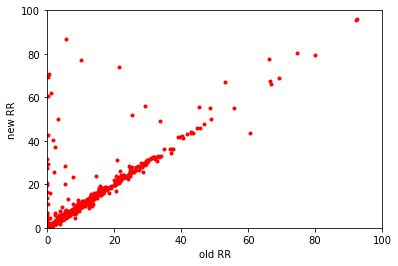

In [128]:
#init lists
DBZ_total = []
ZDR_total = []
KDP_total = []
ATTEN_total = []
TIME_total = []
RAIN_total = []

for infile in file_list:
    #load file and run pytmatrix
    DBZ_out, ZDR_out, KDP_out, ATTEN_out, TIME_out, RAIN_out = mtview_disdro_to_radar_moments(infile, scatterer)
    DBZ_total.extend(DBZ_out)
    ZDR_total.extend(ZDR_out)
    KDP_total.extend(KDP_out)
    ATTEN_total.extend(ATTEN_out)
    TIME_total.extend(TIME_out)
    RAIN_total.extend(RAIN_out)
    break
    
dbz_array = np.array(DBZ_total)
zdr_array = np.array(ZDR_total)
kdp_array = np.array(KDP_total)
att_array = np.array(ATTEN_total)
time_array = np.array(TIME_total)
rain_array = np.array(RAIN_total)

zdr_db_array = 10*np.log10(zdr_array)


In [129]:
#convert zdr to log space
dbz_mask1 = np.logical_or(np.isinf(dbz_array), np.isnan(dbz_array))
dbz_mask2 = np.logical_or(dbz_array<-25, dbz_array>65)
dbz_mask = np.logical_or(dbz_mask1, dbz_mask2)

dbz_array_filt = dbz_array[~dbz_mask]
rain_array_filt = rain_array[~dbz_mask]
zdr_array_filt = zdr_array[~dbz_mask]
kdp_array_filt = kdp_array[~dbz_mask]
att_array_filt = att_array[~dbz_mask]
time_array_filt = time_array[~dbz_mask]

zdr_db_array_filt = 10*np.log10(zdr_array_filt)

In [130]:
np.savez(f'pytmatrix_out/mtview_radarsim_{band}_{cant}deg_{temperature}C.npz', dbz_array=dbz_array_filt, rain_array=rain_array_filt, zdr_db_array=zdr_db_array_filt, kdp_array=kdp_array_filt, att_array=att_array_filt, time_array = time_array_filt)